In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/home/yernar/Desktop/friday/rfm/data.csv', encoding="ISO-8859-1")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df = df[df['Quantity']>0]
df.Quantity.describe()

count    531285.000000
mean         10.655262
std         156.830323
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

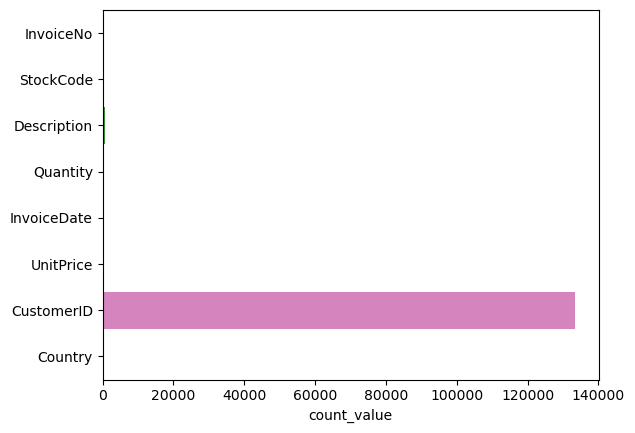

In [5]:
null_values = pd.DataFrame(df.isnull().sum(),columns=['count_value'])
ax = sns.barplot(null_values.count_value,null_values.index)

In [6]:
df.dropna(subset=['CustomerID'],how='all',inplace=True)

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
df['InvoiceDate'].max()

'9/9/2011 9:52'

In [9]:
import datetime as dt
now = dt.date(2011,12,9)

In [10]:
df['date'] = pd.DatetimeIndex(df.InvoiceDate).date

In [11]:
recency_df = df.groupby(['CustomerID'],as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [12]:
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

In [13]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

In [14]:
frequency_df = df.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [15]:
df['Total_cost'] = df['UnitPrice'] * df['Quantity']

In [16]:
monetary_df=df.groupby('CustomerID',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']

In [17]:
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

#combibe rf frame with monetary values..

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)

In [15]:
rfm_segmentation = rfm.copy()

NameError: name 'rfm' is not defined

In [16]:
columns = rfm_segmentation.columns

NameError: name 'rfm_segmentation' is not defined

In [22]:
def weighted_euclidean(X, V, weights):
    dists = X- V
    return np.sqrt(np.sum((dists * weights) **2))

In [23]:

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

X = rfm_segmentation.copy()

np.random.seed(2)
Xts = X
Xts =StandardScaler().fit_transform(Xts)
c= 2
epsilon  = .05
m = 2
d = Xts.shape[1]
n = Xts.shape[0]
V = np.random.random((c, d))
print("V:{}".format(V))

u_0 = np.random.random((n, c))
print("u: {}".format(u_0))

J = np.zeros(0)
num_iter = 0
max_iter = 100
u = u_0
eps = .03
weights = [1,1,1]
um = u ** m 
print("um: {}".format(um))
print("X: {}".format(Xts))

#update cluster centeers matrix
numerator = um.T.dot(Xts)
print("numerator:{}".format(numerator))
denominator = um.T.sum(axis = 1)
print("denominator :{}".format(denominator.T))

V = numerator.T/(denominator)
V = V.T
print("New V:{}".format(V))

# update distance matrix
d = pairwise_distances(Xts, V, metric = weighted_euclidean, **{'weights':weights})
print("d:{}".format(d))
 #update fuzziness
for i in np.arange(0, n):
    for j in np.arange(0, c):
        newdenom = (d[i, j] / d[i, :]) ** (2/(m-1))
        print(newdenom)
        u[i, j] = 1 / np.sum(newdenom)
print("u: {}".format(u))

#update loss
J = (u *d**2).sum()
print("j :{}".format(J))

NameError: name 'rfm_segmentation' is not defined

In [19]:
def update(X, V_0, u2, d_0, m, weights):
    u = u2.copy()
    um = u ** m 
    #update cluster centeers matrix
    numerator = um.T.dot(X)
    denominator = um.T.sum(axis = 1)
    V = numerator.T/(denominator)
    V = V.T
    
    # update distance matrix
    d = pairwise_distances(X, V, metric = weighted_euclidean, **{'weights':weights})
     
    #update fuzziness
    for i in np.arange(0, n):
        for j in np.arange(0, c):
            newdenom = (d[i, j] / d[i, :]) ** (2/(m-1))
            u[i, j] = 1 / np.sum(newdenom, axis = 0)
            
    #update loss
    J = (u *d**2).sum()
        
    return V, u, J, d

In [20]:
np.random.seed(2)
X_ =StandardScaler().fit_transform(X)
c= 3
m = 2
d = X.shape[1]
n = X.shape[0]
V = np.random.random((c, d))
u_0 = np.random.random((n, c))
J = np.zeros(0)
num_iter = 0
max_iter = 100
u = u_0
eps = .03
weights = [1,1,1]
while num_iter < max_iter - 1:
    u2 = u.copy()
    V, u, Jm, d = update(X_, V, u2, d, m, weights)
    J = np.hstack((J, Jm))
    num_iter += 1

    if np.linalg.norm(u - u2) < eps:
        break
error = np.linalg.norm(u - u2)

f_p_coeff = np.trace(u.dot(u.T)) / float(n)

NameError: name 'X' is not defined

In [21]:
print(J)
print(f_p_coeff)

NameError: name 'J' is not defined

In [49]:
def to_color(u):
    colors = []
    for i in range(0, u.shape[0]):
        colors.append(tuple((u[i, 0], u[i, 1], u[i, 2])))
    return colors 
colorlist = to_color(u) 

In [50]:
rfm_segmentation

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


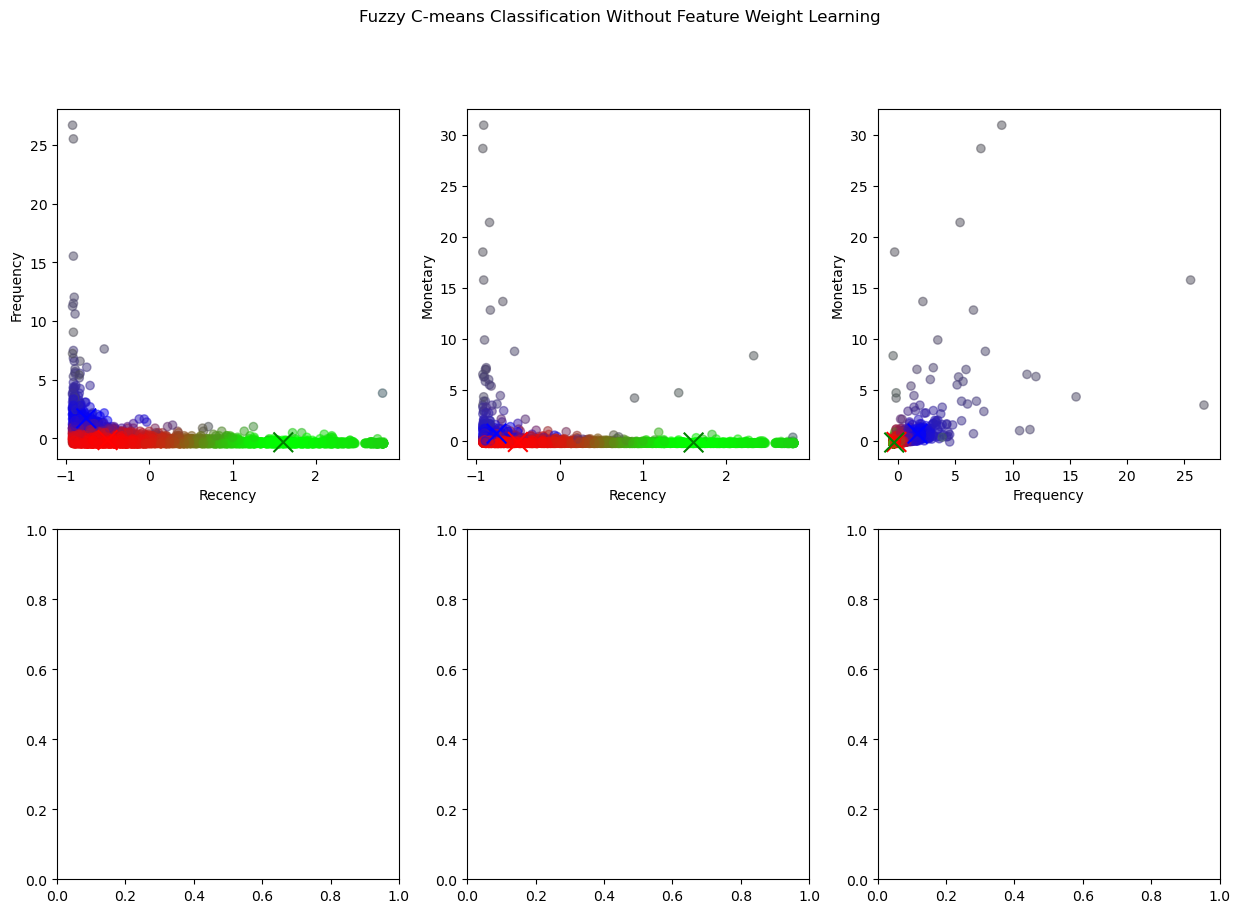

In [51]:
from itertools import combinations


def _2D_Plot(X_, V, colorlist):
    fig, ax = plt.subplots(2,3, figsize = (15,10))
    axlist = [ (i,j) for i in np.arange(0,3) for j in np.arange(0,3)]
    for idx, axcombo in enumerate(combinations([0,1,2], 2)):
        axl = axlist[idx]
        axl = ax[axl[0], axl[1]]
        axl.scatter(X_[:, axcombo[0]], X_[:, axcombo[1]],  c = colorlist, alpha = .5)
        axl.scatter(V[:, axcombo[0]], V[:, axcombo[1]], marker ='x',  c=['red', 'green', 'blue'], s =200)
        axl.set_xlabel(columns[axcombo[0]])
        axl.set_ylabel(columns[axcombo[1]])
    #plt.show()
    return fig
fig = _2D_Plot(X_, V,colorlist)
fig.suptitle("Fuzzy C-means Classification Without Feature Weight Learning")
fig.savefig("Iris_WO.png")
fig.show()

Text(0.5, 0.98, 'Fuzzy Weighted Clustering')

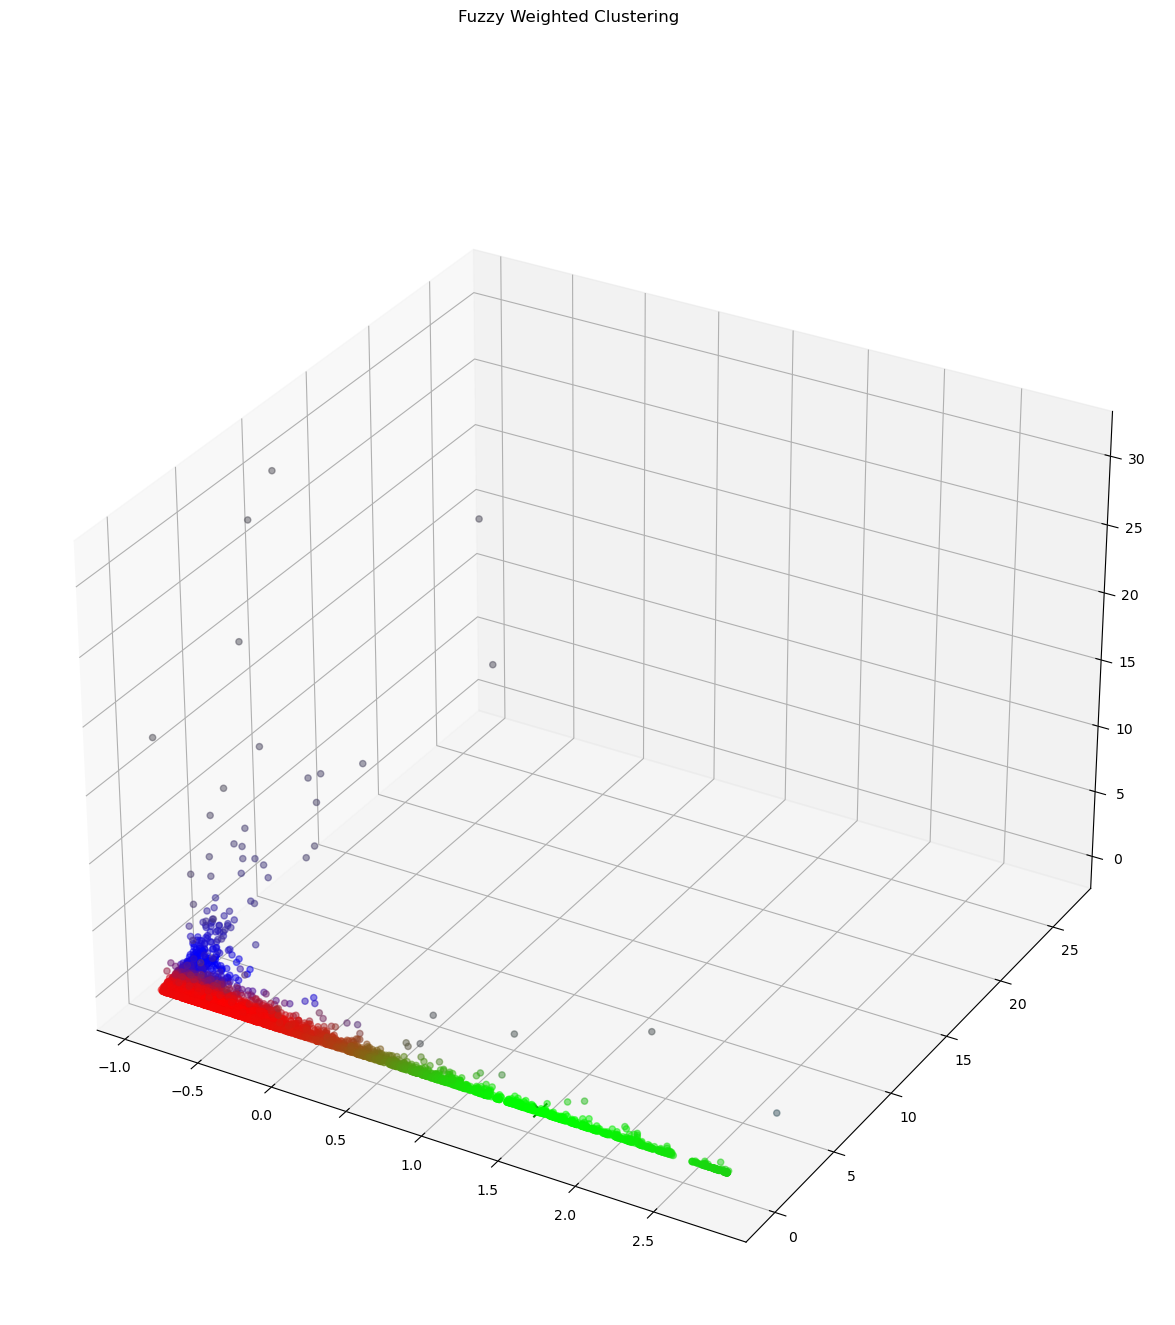

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig3D = plt.figure(figsize=(15, 15))
ax = fig3D.add_subplot(111, projection='3d')
ax.scatter(X_[:, 0], X_[:, 1],X_[:, 2], c= colorlist,  alpha = .5)
ax.scatter(V[:, 0], V[:, 1], V[:, 2],  c= ['red', 'green', 'blue'], marker = 'x', alpha = 1, s = 100)
fig3D.suptitle('Fuzzy Weighted Clustering')

In [46]:
https://www.kaggle.com/code/prateekk94/fuzzy-c-means-clustering-on-iris-dataset

SyntaxError: invalid syntax (4182093924.py, line 1)

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(X)

In [39]:
new_rfm = np.array([[4, 3, 5]])
new_rfm_scaled = scaler.transform(new_rfm)
new_rfm_scaled

array([[-0.88044801, -0.16508985, -0.22796757]])

# 

# 

# 

https://medium.com/@ugursavci/step-by-step-customer-segmentation-using-k-means-and-pca-in-python-5733822295b6

In [152]:
### Data Analysis and Manipulation 
import pandas as pd 
import numpy as np### Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() ## this is for styling
### Data Standardization and Modeling with K-Means and PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [175]:
df= pd.read_csv('marketing_campaign.csv', delimiter='\t', index_col = 0)
df = df.drop('Education', axis=1)
df = df.drop('Marital_Status', axis=1)
df = df.drop('Dt_Customer', axis=1)
df = df.drop('AcceptedCmp3', axis=1)
df = df.drop('AcceptedCmp4', axis=1)
df = df.drop('AcceptedCmp5', axis=1)
df = df.drop('AcceptedCmp1', axis=1)
df = df.drop('AcceptedCmp2', axis=1)
df = df.drop('Complain', axis=1)
df = df.drop('Z_CostContact', axis=1)
df = df.drop('Income', axis=1)
df = df.drop('Z_Revenue', axis=1)

In [176]:
df.head()

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
ID,,,,,,,,,,,,,,,,
5524,1957,0,0,58,635,88,546,172,88,88,3,8,10,4,7,1
2174,1954,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0
4141,1965,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0
6182,1984,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0
5324,1981,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0


In [177]:
df.describe()

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107
std,11.984069,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274
min,1893.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000
50%,1970.000000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000
75%,1977.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000
max,1996.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Year_Birth           2240 non-null   int64
 1   Kidhome              2240 non-null   int64
 2   Teenhome             2240 non-null   int64
 3   Recency              2240 non-null   int64
 4   MntWines             2240 non-null   int64
 5   MntFruits            2240 non-null   int64
 6   MntMeatProducts      2240 non-null   int64
 7   MntFishProducts      2240 non-null   int64
 8   MntSweetProducts     2240 non-null   int64
 9   MntGoldProds         2240 non-null   int64
 10  NumDealsPurchases    2240 non-null   int64
 11  NumWebPurchases      2240 non-null   int64
 12  NumCatalogPurchases  2240 non-null   int64
 13  NumStorePurchases    2240 non-null   int64
 14  NumWebVisitsMonth    2240 non-null   int64
 15  Response             2240 non-null   int64
dtypes: int64(16)
memory u

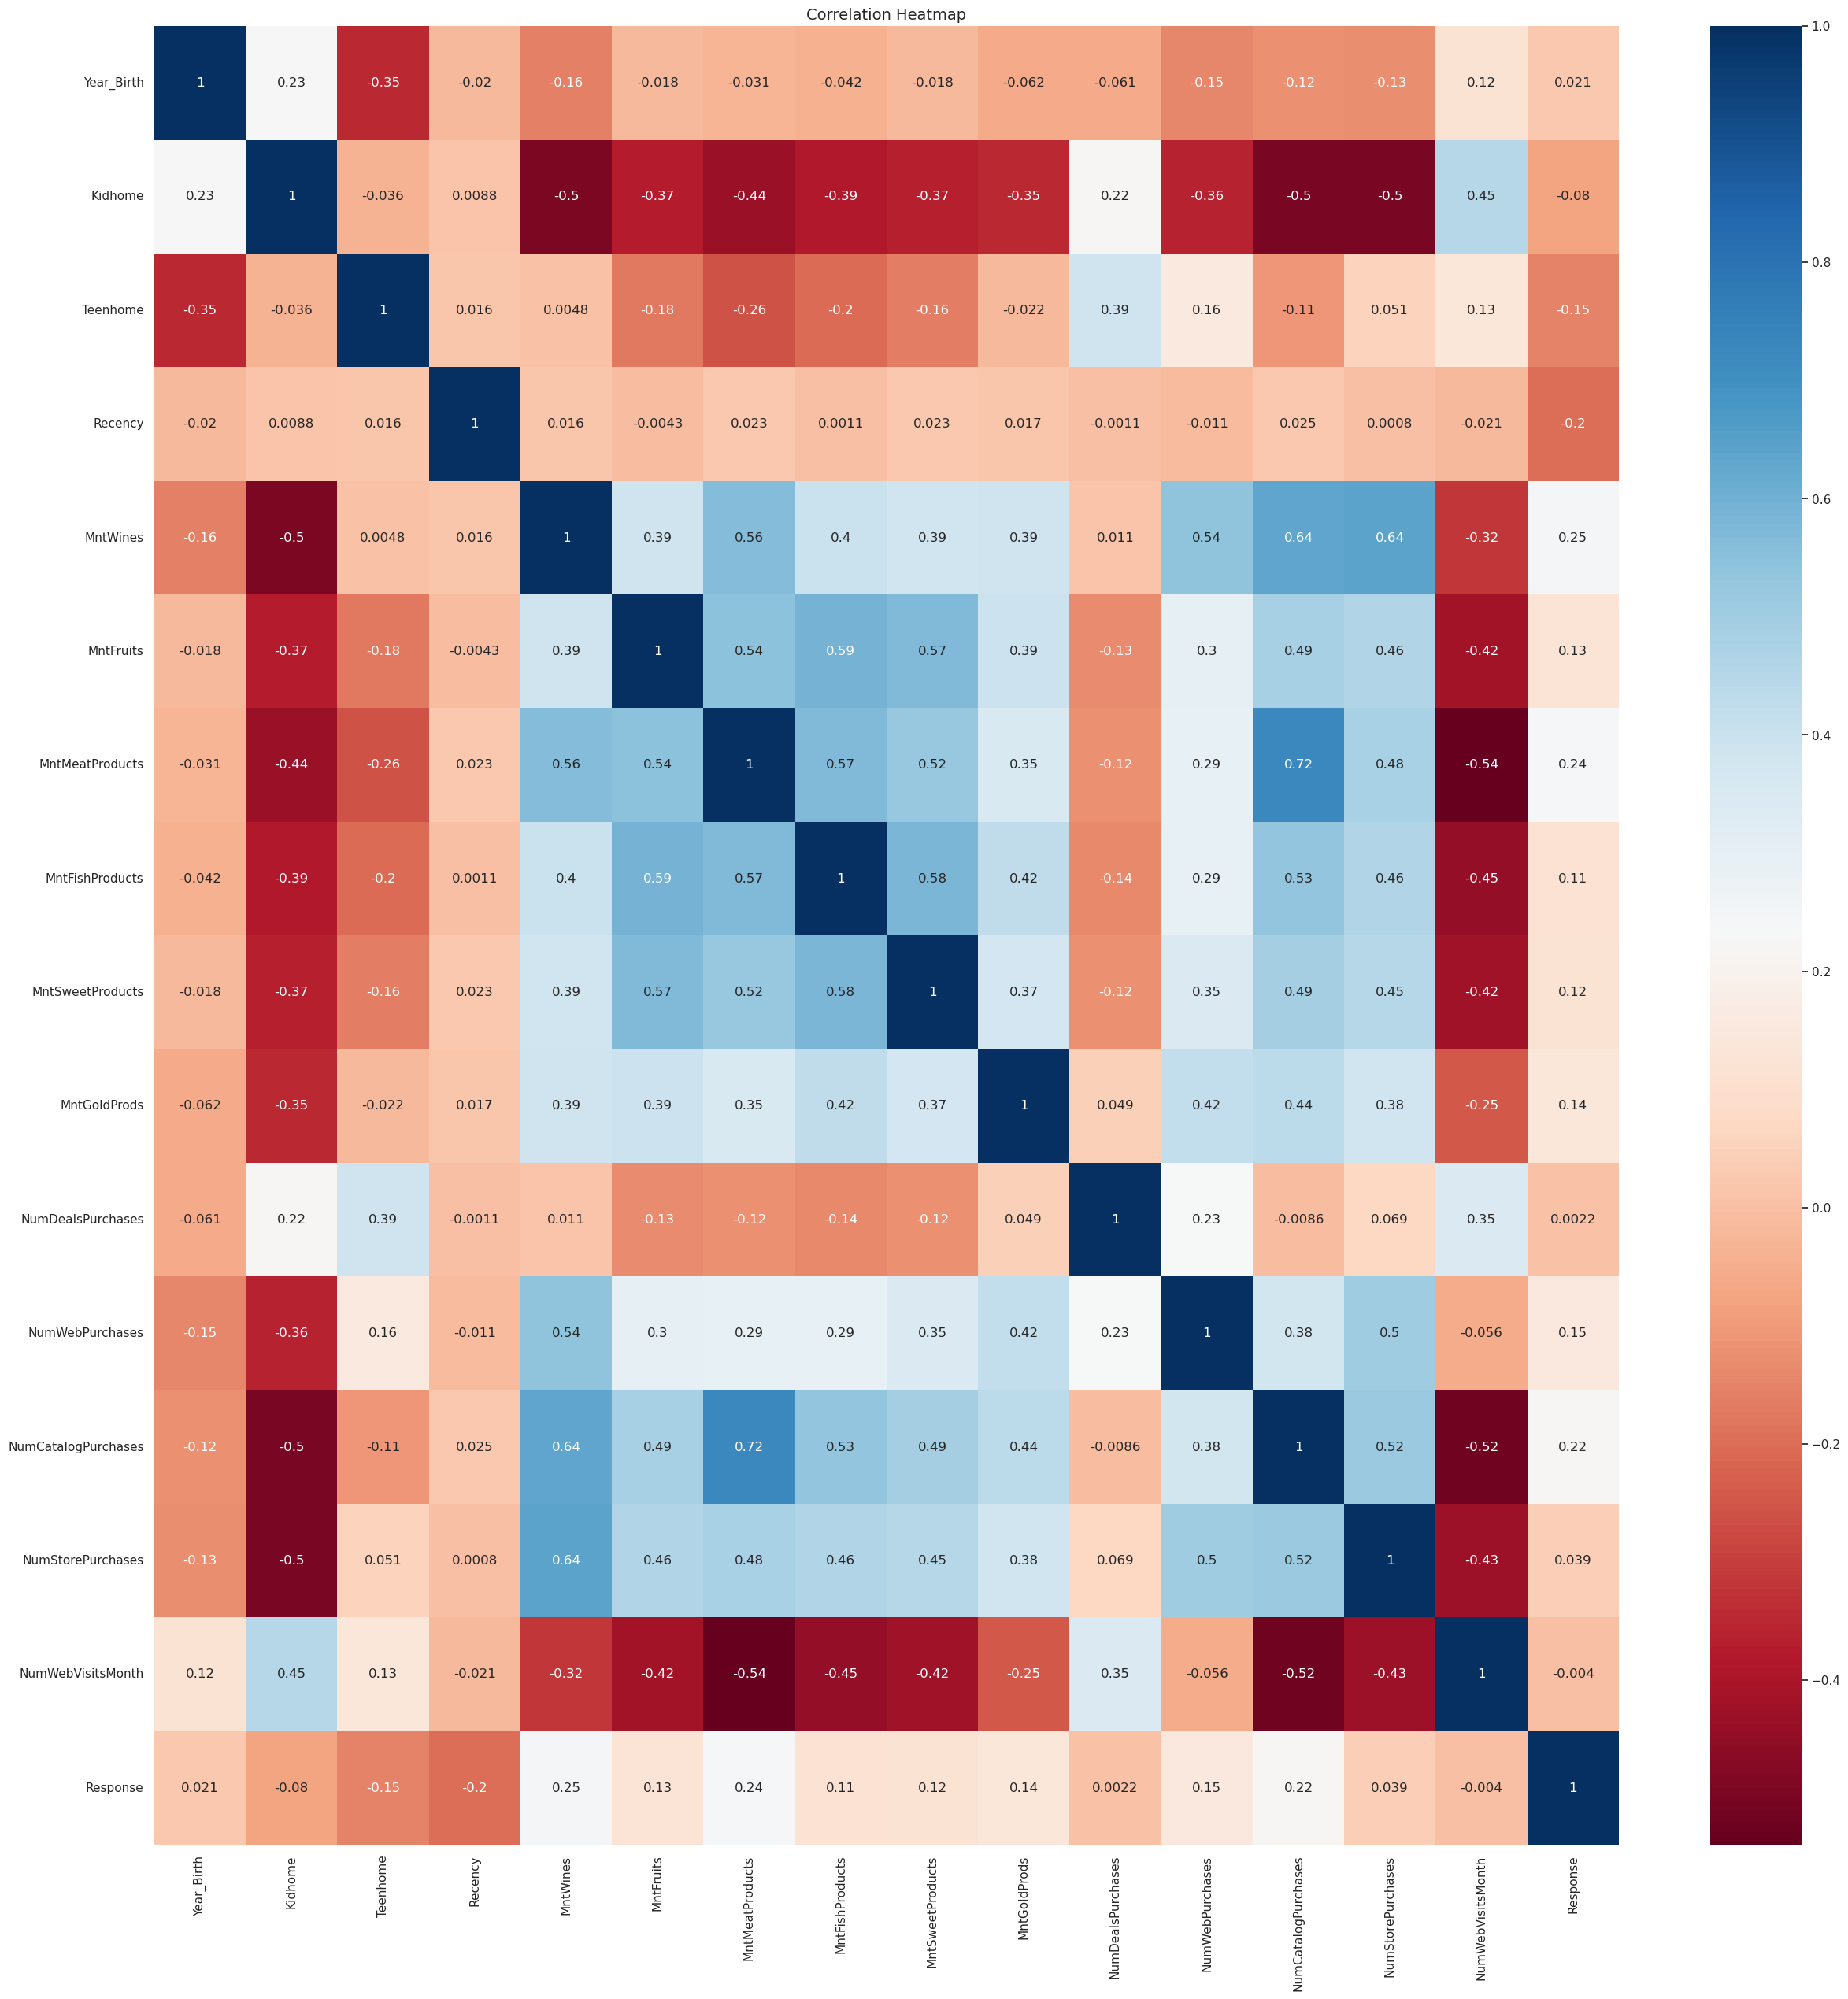

In [179]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

In [180]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [198]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

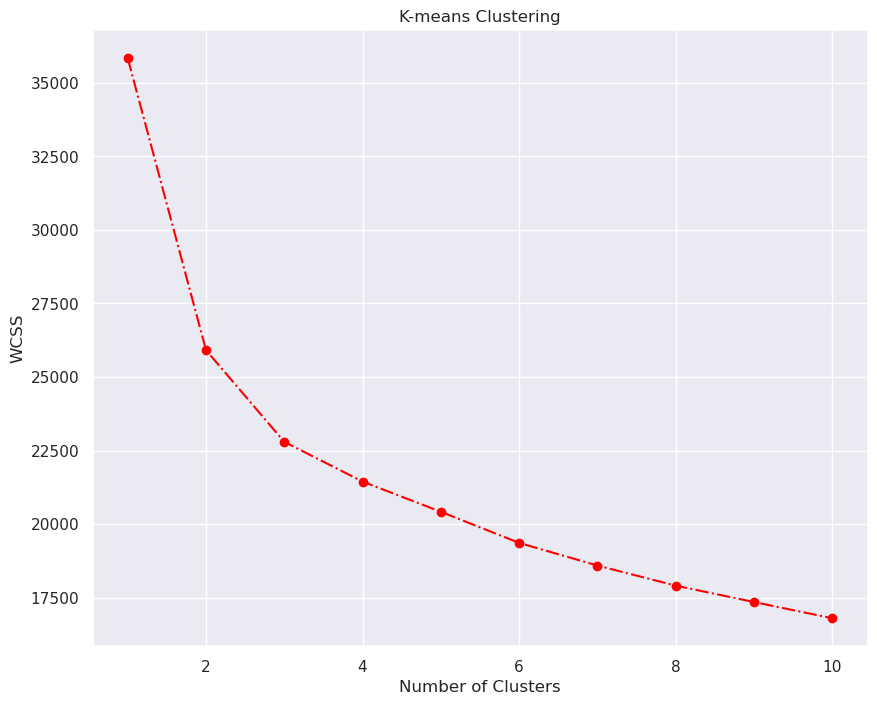

In [185]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [199]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [200]:


# We divide our data into the four clusters.
kmeans.fit(df_std)



KMeans(n_clusters=4, random_state=42)

In [201]:


# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans= df_std.copy()
df_segm_kmeans = pd.DataFrame(data = df_std,columns = df.columns)
df_segm_kmeans['Segment K-means'] = kmeans.labels_



In [202]:
df_segm_kmeans.head()

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Segment K-means
0,-0.985345,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,2.388846,1
1,-1.235733,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.418612,2
2,-0.317643,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.418612,1
3,1.268149,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.418612,0
4,1.017761,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.418612,0


In [203]:
# Calculate mean values for the clusters
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis.head()

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
Segment K-means,,,,,,,,,,,,,,,,
0,0.804849,0.770011,-0.929894,-0.023671,-0.801341,-0.497290,-0.623187,-0.518255,-0.498564,-0.513194,-0.232132,-0.666739,-0.729097,-0.819377,0.634178,-0.082119
1,-0.031971,-0.746365,-0.621158,0.014223,0.860191,1.079955,1.278413,1.157424,1.059861,0.657626,-0.513629,0.403374,1.138689,0.795860,-1.008715,0.391690
2,-0.419996,0.535623,0.827565,0.046960,-0.745961,-0.574932,-0.649372,-0.607840,-0.571925,-0.595226,-0.020184,-0.747488,-0.711646,-0.759697,0.272391,-0.256866
3,-0.374524,-0.414422,0.797816,-0.029650,0.501377,-0.129855,-0.146912,-0.159419,-0.111559,0.311574,0.729537,0.822440,0.136530,0.591555,0.176974,-0.098951


In [204]:
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard'})

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
Segment K-means,,,,,,,,,,,,,,,,
well-off,0.804849,0.770011,-0.929894,-0.023671,-0.801341,-0.497290,-0.623187,-0.518255,-0.498564,-0.513194,-0.232132,-0.666739,-0.729097,-0.819377,0.634178,-0.082119
fewer-opportunities,-0.031971,-0.746365,-0.621158,0.014223,0.860191,1.079955,1.278413,1.157424,1.059861,0.657626,-0.513629,0.403374,1.138689,0.795860,-1.008715,0.391690
standard,-0.419996,0.535623,0.827565,0.046960,-0.745961,-0.574932,-0.649372,-0.607840,-0.571925,-0.595226,-0.020184,-0.747488,-0.711646,-0.759697,0.272391,-0.256866
3,-0.374524,-0.414422,0.797816,-0.029650,0.501377,-0.129855,-0.146912,-0.159419,-0.111559,0.311574,0.729537,0.822440,0.136530,0.591555,0.176974,-0.098951


In [205]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'standard'})


In [206]:
df_segm_kmeans.head()

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Segment K-means,Labels
0,-0.985345,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,2.388846,1,fewer opportunities
1,-1.235733,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.418612,2,standard
2,-0.317643,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.418612,1,fewer opportunities
3,1.268149,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.418612,0,well-off
4,1.017761,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.418612,0,well-off


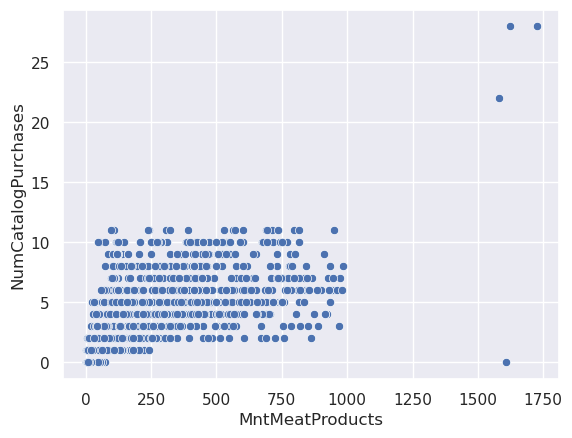

<Figure size 1000x800 with 0 Axes>

In [208]:
sns.scatterplot(data=df, x="MntMeatProducts", y="NumCatalogPurchases")
plt.figure(figsize = (10, 8))
plt.show()

In [181]:
df_std = pd.DataFrame(data = df_std,columns = df.columns)
df_std

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
0,-0.985345,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,2.388846
1,-1.235733,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,-0.418612
2,-0.317643,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,-0.418612
3,1.268149,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-0.418612
4,1.017761,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-0.418612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.150717,-0.825218,0.906934,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,-0.168236,1.769263,0.115638,-0.550785,-0.130463,-0.418612
2236,-1.903435,2.890335,0.906934,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,2.420015,1.409304,-0.226541,-0.243114,0.693904,-0.418612
2237,1.017761,-0.825218,-0.929894,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,-0.685887,-0.750450,0.115638,2.218248,0.281720,-0.418612
2238,-1.068807,-0.825218,0.906934,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,-0.168236,0.689386,0.799996,1.295237,-0.954831,-0.418612


In [182]:
pca = PCA()
pca.fit(df_std) 

PCA()

In [183]:
pca.transform(df_std)
scores_pca = pca.transform(df_std)

In [184]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

In [186]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [187]:
kmeans.fit(df_std)

KMeans(n_clusters=3, random_state=42)

In [188]:
df_segm_kmeans= df_std.copy()
df_std['Segment K-means'] = kmeans.labels_

In [189]:
df_segm_analysis = df_std.groupby(['Segment K-means']).mean()
df_segm_analysis

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
Segment K-means,,,,,,,,,,,,,,,,
0,0.235208,0.661003,-0.112550,0.009178,-0.775585,-0.533399,-0.635365,-0.559919,-0.532682,-0.551345,-0.133561,-0.704293,-0.720981,-0.791621,0.465921,-0.163389
1,-0.031971,-0.746365,-0.621158,0.014223,0.860191,1.079955,1.278413,1.157424,1.059861,0.657626,-0.513629,0.403374,1.138689,0.795860,-1.008715,0.391690
2,-0.374524,-0.414422,0.797816,-0.029650,0.501377,-0.129855,-0.146912,-0.159419,-0.111559,0.311574,0.729537,0.822440,0.136530,0.591555,0.176974,-0.098951


In [190]:
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard'})

,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response
Segment K-means,,,,,,,,,,,,,,,,
well-off,0.235208,0.661003,-0.112550,0.009178,-0.775585,-0.533399,-0.635365,-0.559919,-0.532682,-0.551345,-0.133561,-0.704293,-0.720981,-0.791621,0.465921,-0.163389
fewer-opportunities,-0.031971,-0.746365,-0.621158,0.014223,0.860191,1.079955,1.278413,1.157424,1.059861,0.657626,-0.513629,0.403374,1.138689,0.795860,-1.008715,0.391690
standard,-0.374524,-0.414422,0.797816,-0.029650,0.501377,-0.129855,-0.146912,-0.159419,-0.111559,0.311574,0.729537,0.822440,0.136530,0.591555,0.176974,-0.098951


In [192]:
pca = PCA()
pca.fit(df_std)

PCA()

In [193]:
pca.explained_variance_ratio_

array([0.3496442 , 0.13082671, 0.08021724, 0.06663391, 0.05274162,
       0.04797281, 0.04415881, 0.03703777, 0.03182364, 0.02685167,
       0.02615352, 0.02354722, 0.02293733, 0.02088652, 0.01516749,
       0.01314961, 0.01024994])

Text(0, 0.5, 'Cumulative Explained Variance')

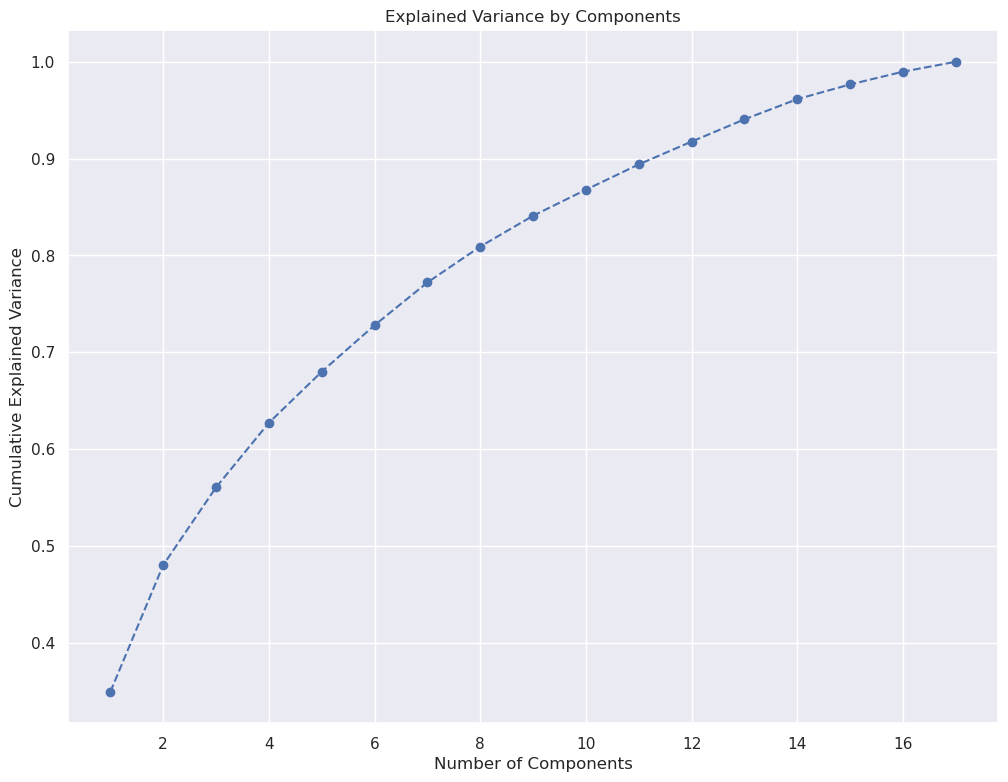

In [195]:
plt.figure(figsize = (12,9))
plt.plot(range(1,18), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [196]:
pca = PCA(n_components = 3)
pca.fit(df_std)
pca.components_

array([[-0.06956364, -0.28174822, -0.04153245,  0.00223883,  0.31635856,
         0.2895656 ,  0.32315987,  0.29890375,  0.28809896,  0.24889129,
        -0.03502176,  0.24274765,  0.33663435,  0.31440045, -0.25362   ,
         0.09385951,  0.21433218],
       [-0.28613101, -0.04376788,  0.51075265,  0.00633776,  0.14597406,
        -0.15750653, -0.17112926, -0.16804091, -0.13875448,  0.08133868,
         0.46534065,  0.33585643, -0.0272714 ,  0.1529319 ,  0.23072794,
        -0.05359405,  0.34090383],
       [ 0.39365741,  0.23950363, -0.24064757, -0.37032314,  0.09032218,
         0.0235229 ,  0.05595838,  0.00161173,  0.014183  ,  0.12702259,
         0.28449537,  0.20090253,  0.03028495, -0.0587842 ,  0.34646832,
         0.56455642,  0.0019158 ]])

In [197]:


df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp



ValueError: Shape of passed values is (3, 17), indices imply (3, 16)